# MAP 536 - Python for Data Science - Predicting Cyclist Traffic in Paris

You can just copy this code to merge - dataset is on github - double click on this cell first:

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

#Load training and testing datasets & remove unnecessary cols
train_data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "test.parquet")
train_data.drop(columns=['counter_name', 'site_name','counter_id', 'counter_installation_date', 'counter_technical_id', 'site_id'], inplace=True)
test_data.drop(columns=['counter_name', 'site_name','counter_id', 'counter_installation_date', 'counter_technical_id', 'site_id'], inplace=True)

#Load weather dataset and remove irrelevant columns
weather_data = pd.read_csv(Path("data") / "hourly-weather-data.csv")
weather_data = weather_data.drop(columns=['name', 'dew', 'precipprob', 'preciptype','uvindex','icon','stations', 'sealevelpressure', 'winddir', 'conditions', 'sealevelpressure', 'severerisk', 'solarradiation', 'solarenergy'])

#convert to datetime to merge them properly
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

#merge them and remove one of the date cols
merged_train_data = pd.merge(train_data, weather_data, left_on='date', right_on='datetime', how='inner')
merged_test_data = pd.merge(test_data, weather_data, left_on='date', right_on='datetime', how='inner')
merged_train_data = merged_train_data.drop(columns=['datetime'])
merged_test_data = merged_test_data.drop(columns=['datetime'])

#encode the dates
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    X['date'] = pd.to_datetime(X['date'])
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    return X.drop(columns=["date"])

merged_train_data = _encode_dates(merged_train_data)
merged_test_data = _encode_dates(merged_test_data)




### Merging Train, Test & Weather Data

In [51]:

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit


In [52]:
# Load training and testing datasets
train_data = pd.read_parquet(Path("data") / "train.parquet")
test_data = pd.read_parquet(Path("data") / "test.parquet")

train_data.drop(columns=['counter_name', 'site_name','counter_id', 'counter_installation_date', 'counter_technical_id', 'site_id'], inplace=True)
test_data.drop(columns=['counter_name', 'site_name','counter_id', 'counter_installation_date', 'counter_technical_id', 'site_id'], inplace=True)
train_data.tail()

,bike_count,date,latitude,longitude,log_bike_count
928450,51.0,2021-08-08 18:00:00,48.83977,2.30198,3.951244
928453,1.0,2021-08-09 02:00:00,48.83977,2.30198,0.693147
928456,61.0,2021-08-09 08:00:00,48.83977,2.30198,4.127134
928459,44.0,2021-08-09 10:00:00,48.83977,2.30198,3.806662
928462,83.0,2021-08-09 17:00:00,48.83977,2.30198,4.430817


In [53]:
weather_data = pd.read_csv(Path("data") / "hourly-weather-data.csv")
weather_data = weather_data.drop(columns=['name', 'dew', 'precipprob', 'preciptype','uvindex','icon','stations', 'sealevelpressure', 'winddir', 'conditions', 'sealevelpressure', 'severerisk', 'solarradiation', 'solarenergy'])

weather_data.info()
weather_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20423 entries, 0 to 20422
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    20423 non-null  object 
 1   temp        20423 non-null  float64
 2   feelslike   20423 non-null  float64
 3   humidity    20423 non-null  float64
 4   precip      20423 non-null  float64
 5   snow        20419 non-null  float64
 6   snowdepth   20419 non-null  float64
 7   windgust    20267 non-null  float64
 8   windspeed   20423 non-null  float64
 9   cloudcover  20423 non-null  float64
 10  visibility  20419 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


,datetime,temp,feelslike,humidity,precip,snow,snowdepth,windgust,windspeed,cloudcover,visibility
20418,2022-04-30T19:00:00,16.4,16.4,41.40,0.0,0.0,0.0,42.2,16.1,24.2,22.0
20419,2022-04-30T20:00:00,14.8,14.8,42.28,0.0,0.0,0.0,42.9,18.5,15.8,21.7
20420,2022-04-30T21:00:00,13.2,13.2,49.26,0.0,0.0,0.0,35.3,15.9,15.8,23.5
20421,2022-04-30T22:00:00,12.3,12.3,52.47,0.0,0.0,0.0,31.9,12.7,32.6,22.7
20422,2022-04-30T23:00:00,11.6,11.6,52.26,0.0,0.0,0.0,36.7,17.8,46.7,24.6


In [54]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
weather_data.head()


,datetime,temp,feelslike,humidity,precip,snow,snowdepth,windgust,windspeed,cloudcover,visibility
0,2020-01-01 00:00:00,1.0,-1.8,92.21,0.0,0.0,0.0,14.8,8.8,21.3,3.9
1,2020-01-01 01:00:00,0.3,-1.4,93.99,0.0,0.0,0.0,14.5,5.3,87.5,1.7
2,2020-01-01 02:00:00,-0.7,-3.8,95.71,0.0,0.0,0.0,16.9,8.9,87.0,0.9
3,2020-01-01 03:00:00,-0.5,-3.4,97.66,0.0,0.0,0.0,19.9,8.2,80.0,0.9
4,2020-01-01 04:00:00,-0.1,-2.1,97.36,0.0,0.0,0.0,21.8,5.8,97.2,0.1


In [55]:
train_data.tail()

,bike_count,date,latitude,longitude,log_bike_count
928450,51.0,2021-08-08 18:00:00,48.83977,2.30198,3.951244
928453,1.0,2021-08-09 02:00:00,48.83977,2.30198,0.693147
928456,61.0,2021-08-09 08:00:00,48.83977,2.30198,4.127134
928459,44.0,2021-08-09 10:00:00,48.83977,2.30198,3.806662
928462,83.0,2021-08-09 17:00:00,48.83977,2.30198,4.430817


In [56]:
merged_train_data = pd.merge(train_data, weather_data, left_on='date', right_on='datetime', how='inner')
merged_test_data = pd.merge(test_data, weather_data, left_on='date', right_on='datetime', how='inner')
merged_train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455163 entries, 0 to 455162
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   bike_count      455163 non-null  float64       
 1   date            455163 non-null  datetime64[us]
 2   latitude        455163 non-null  float64       
 3   longitude       455163 non-null  float64       
 4   log_bike_count  455163 non-null  float64       
 5   datetime        455163 non-null  datetime64[ns]
 6   temp            455163 non-null  float64       
 7   feelslike       455163 non-null  float64       
 8   humidity        455163 non-null  float64       
 9   precip          455163 non-null  float64       
 10  snow            454997 non-null  float64       
 11  snowdepth       454997 non-null  float64       
 12  windgust        448063 non-null  float64       
 13  windspeed       455163 non-null  float64       
 14  cloudcover      455163 non-null  flo

In [57]:
merged_train_data.head()

,bike_count,date,latitude,longitude,log_bike_count,datetime,temp,feelslike,humidity,precip,snow,snowdepth,windgust,windspeed,cloudcover,visibility
0,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2020-09-01 02:00:00,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
1,2.0,2020-09-01 02:00:00,48.846028,2.375429,1.098612,2020-09-01 02:00:00,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
2,5.0,2020-09-01 02:00:00,48.834360,2.377000,1.791759,2020-09-01 02:00:00,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
3,1.0,2020-09-01 02:00:00,48.834360,2.377000,0.693147,2020-09-01 02:00:00,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
4,0.0,2020-09-01 02:00:00,48.853720,2.357020,0.000000,2020-09-01 02:00:00,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4


In [58]:
merged_train_data = merged_train_data.drop(columns=['datetime'])
merged_test_data = merged_test_data.drop(columns=['datetime'])


merged_train_data.head()

,bike_count,date,latitude,longitude,log_bike_count,temp,feelslike,humidity,precip,snow,snowdepth,windgust,windspeed,cloudcover,visibility
0,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
1,2.0,2020-09-01 02:00:00,48.846028,2.375429,1.098612,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
2,5.0,2020-09-01 02:00:00,48.834360,2.377000,1.791759,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
3,1.0,2020-09-01 02:00:00,48.834360,2.377000,0.693147,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4
4,0.0,2020-09-01 02:00:00,48.853720,2.357020,0.000000,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4


In [59]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    X['date'] = pd.to_datetime(X['date'])
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    return X.drop(columns=["date"])

merged_train_data = _encode_dates(merged_train_data)
merged_train_data.head()

,bike_count,latitude,longitude,log_bike_count,temp,feelslike,humidity,precip,snow,snowdepth,windgust,windspeed,cloudcover,visibility,year,month,day,weekday
0,0.0,48.846028,2.375429,0.000000,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4,2020,9,1,1
1,2.0,48.846028,2.375429,1.098612,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4,2020,9,1,1
2,5.0,48.834360,2.377000,1.791759,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4,2020,9,1,1
3,1.0,48.834360,2.377000,0.693147,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4,2020,9,1,1
4,0.0,48.853720,2.357020,0.000000,13.3,13.3,77.67,0.0,0.0,0.0,13.6,7.0,10.0,26.4,2020,9,1,1


In [60]:
merged_test_data = _encode_dates(merged_test_data)
merged_test_data.head()

,bike_count,latitude,longitude,log_bike_count,temp,feelslike,humidity,precip,snow,snowdepth,windgust,windspeed,cloudcover,visibility,year,month,day,weekday
0,1.0,48.846028,2.375429,0.693147,16.1,16.1,94.09,0.0,0.0,0.0,22.4,7.3,95.2,13.9,2021,8,10,1
1,16.0,48.846028,2.375429,2.833213,16.1,16.1,94.09,0.0,0.0,0.0,22.4,7.3,95.2,13.9,2021,8,10,1
2,17.0,48.834360,2.377000,2.890372,16.1,16.1,94.09,0.0,0.0,0.0,22.4,7.3,95.2,13.9,2021,8,10,1
3,53.0,48.834360,2.377000,3.988984,16.1,16.1,94.09,0.0,0.0,0.0,22.4,7.3,95.2,13.9,2021,8,10,1
4,10.0,48.853720,2.357020,2.397895,16.1,16.1,94.09,0.0,0.0,0.0,22.4,7.3,95.2,13.9,2021,8,10,1


### Linear Regression

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


In [41]:
X_merged_train_data = merged_train_data.drop(columns=['bike_count', 'log_bike_count'])
Y_merged_train_data = merged_train_data['log_bike_count']


In [45]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale the data
    ('regressor', LinearRegression())  # Apply linear regression
])

X_merged_train_data = X_merged_train_data.fillna(X_merged_train_data.mean())

from sklearn.model_selection import KFold

# Create a KFold object with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Use this in cross_val_score
scores = cross_val_score(pipeline, X_merged_train_data, Y_merged_train_data, cv=kf, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
rmse_scores = np.sqrt(-scores)


In [46]:
print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

RMSE scores for each fold: [1.56920943 1.56830757 1.57231961 1.57333465 1.57953239]
Average RMSE: 1.5725407274189258


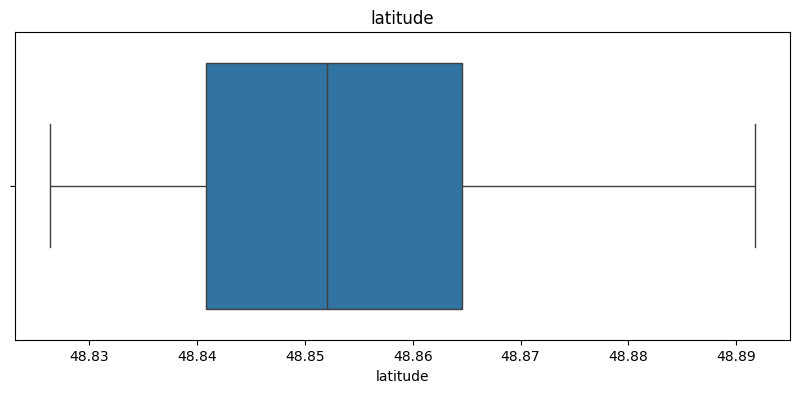

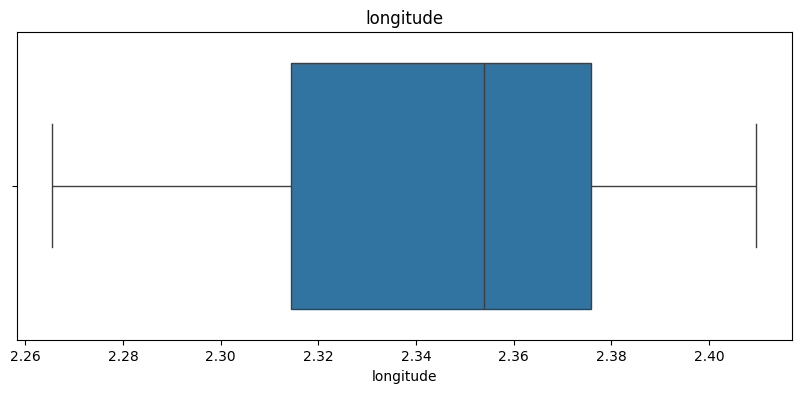

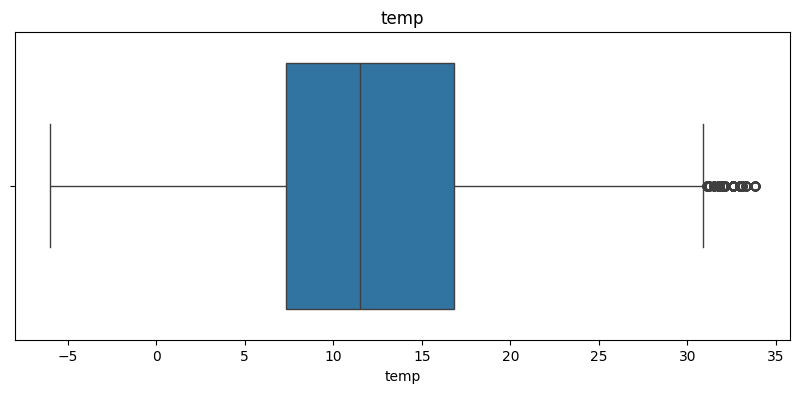

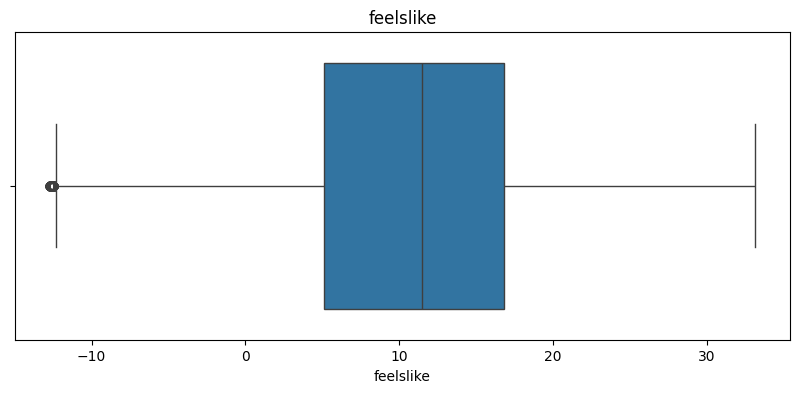

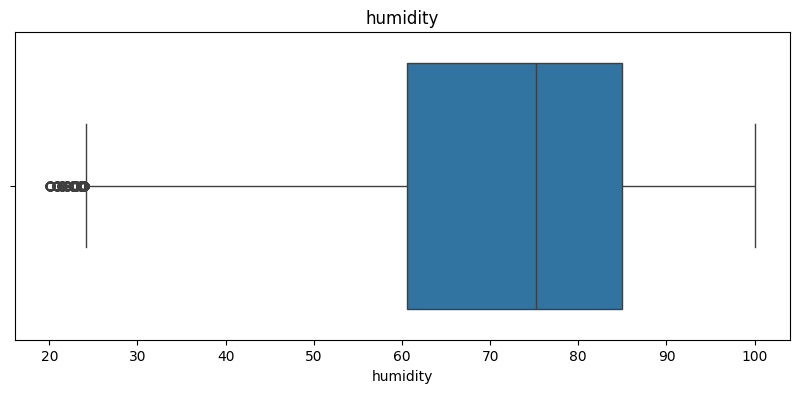

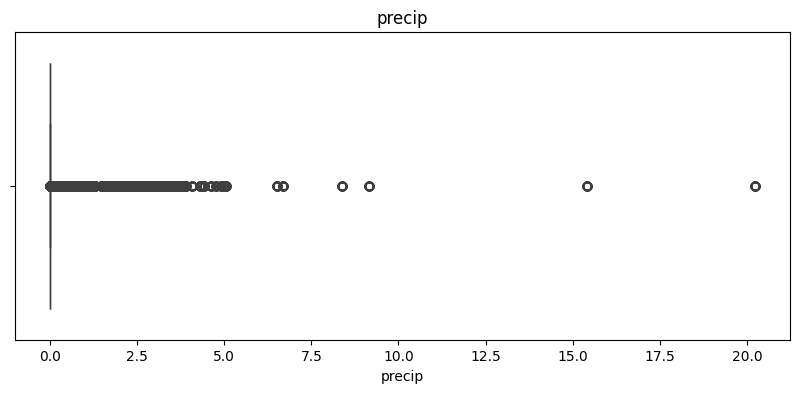

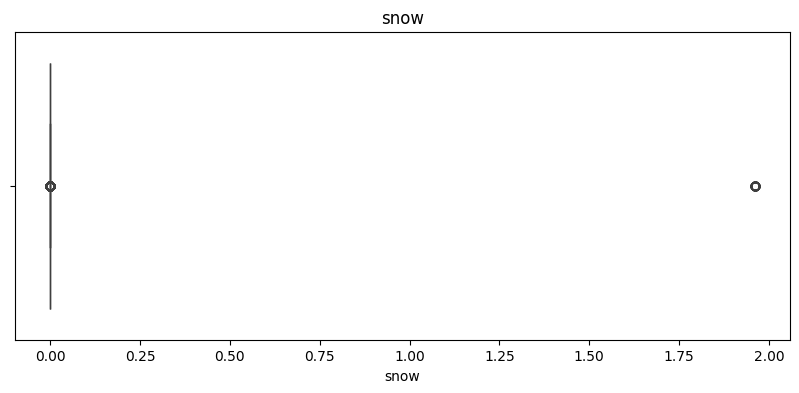

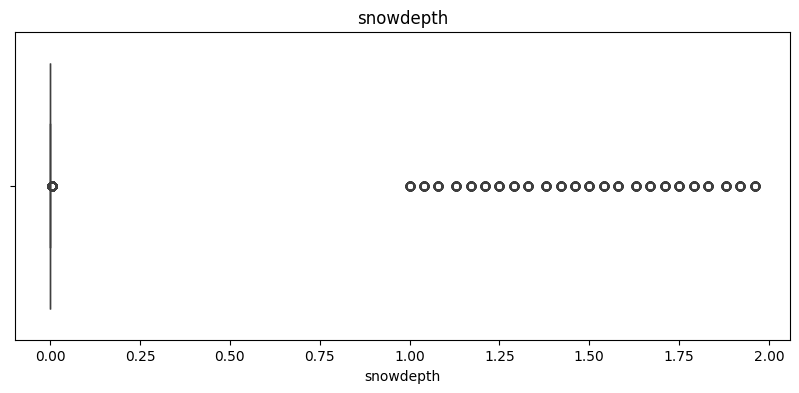

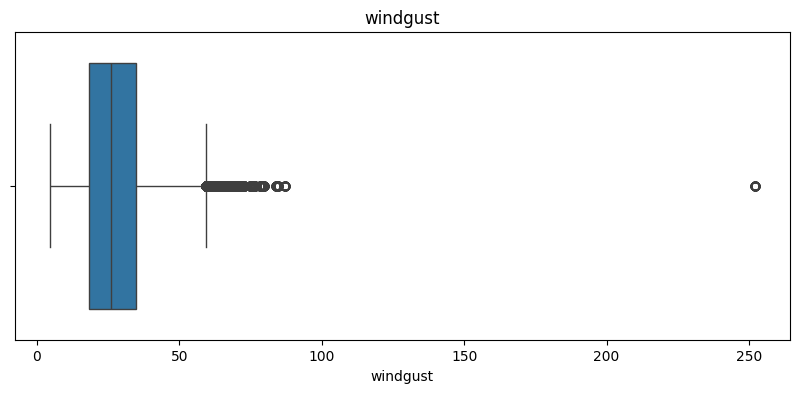

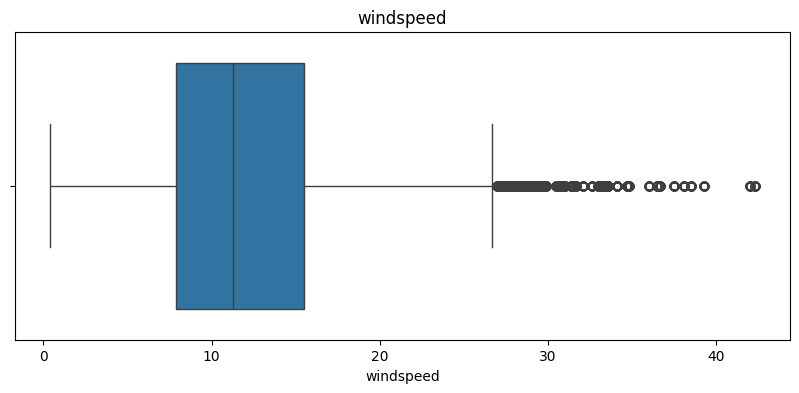

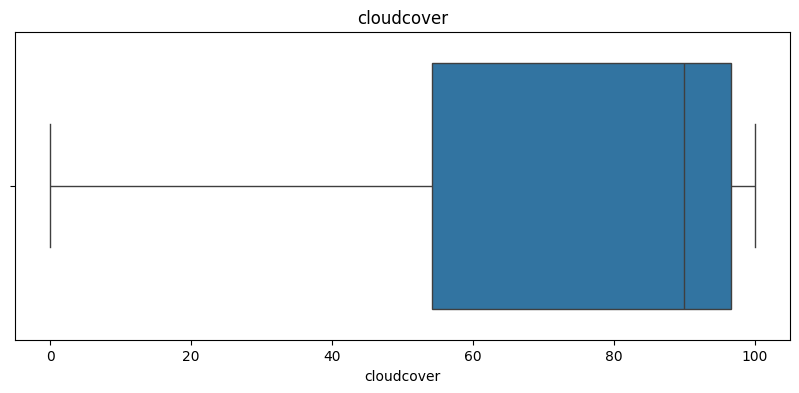

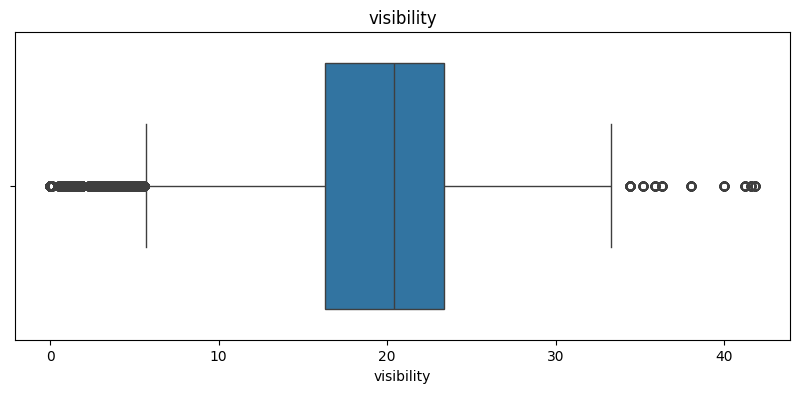

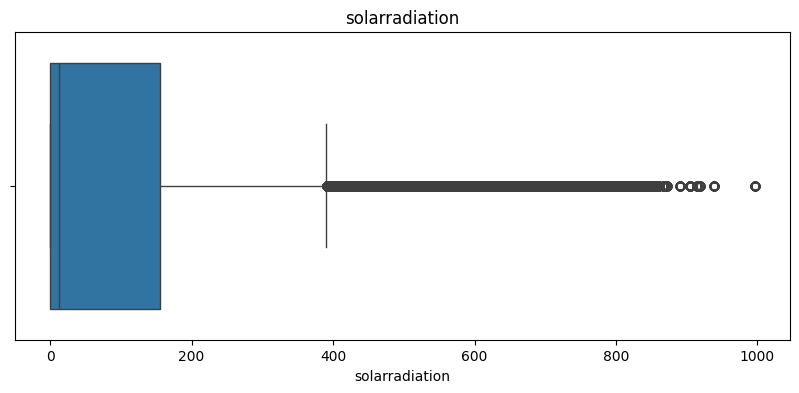

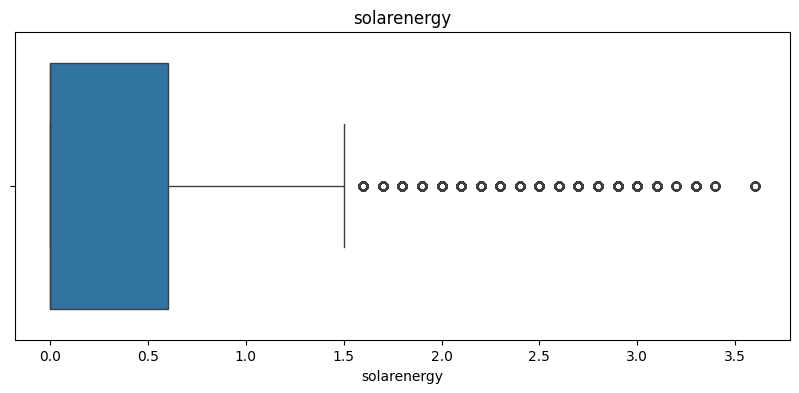

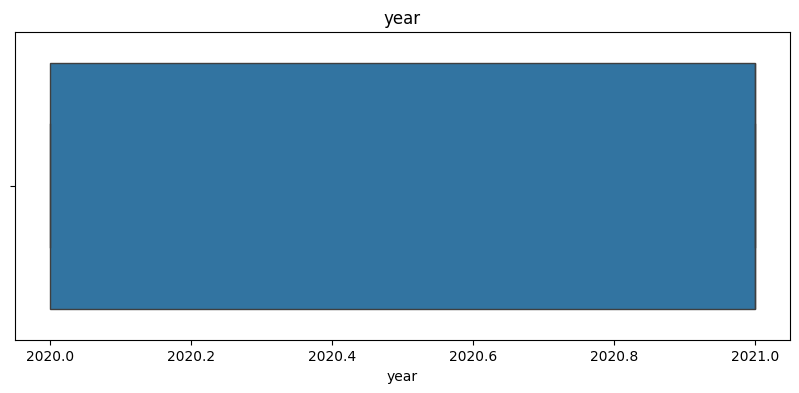

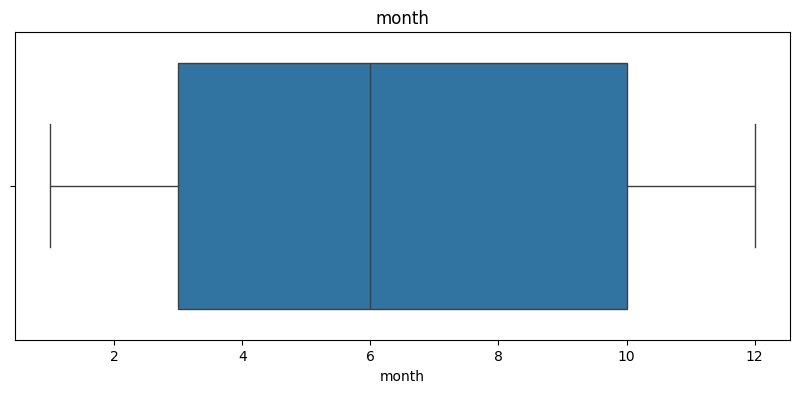

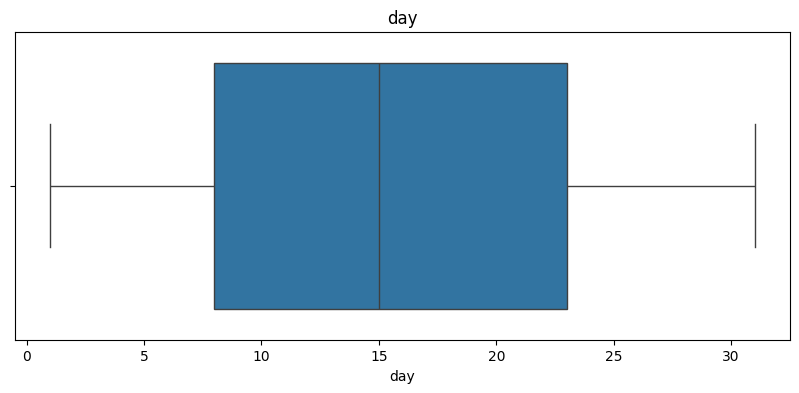

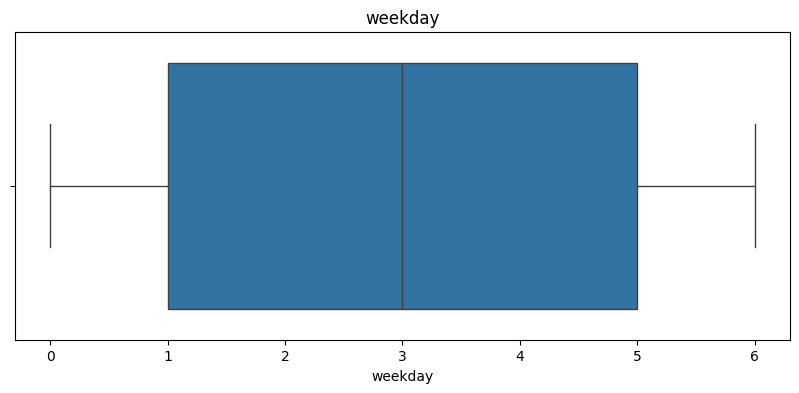

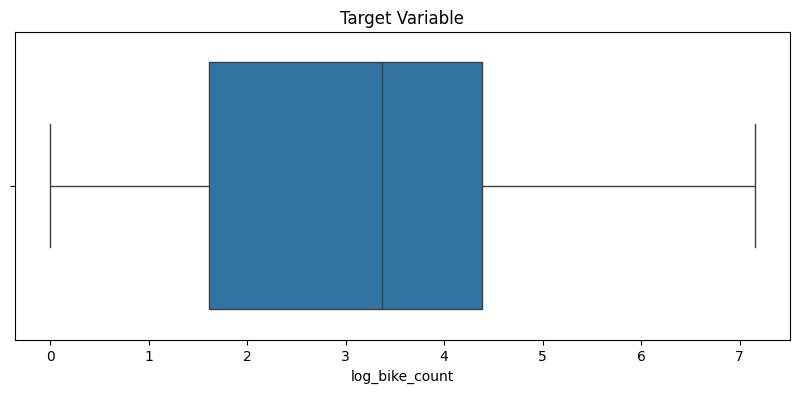

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# For features
for column in X_merged_train_data.columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=X_merged_train_data[column])
    plt.title(column)
    plt.show()

# For target variable
plt.figure(figsize=(10, 4))
sns.boxplot(x=Y_merged_train_data)
plt.title('Target Variable')
plt.show()
